<a href="https://colab.research.google.com/github/serfrol/sber_internship/blob/main/Amazon_Toy_Price_Prediction_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

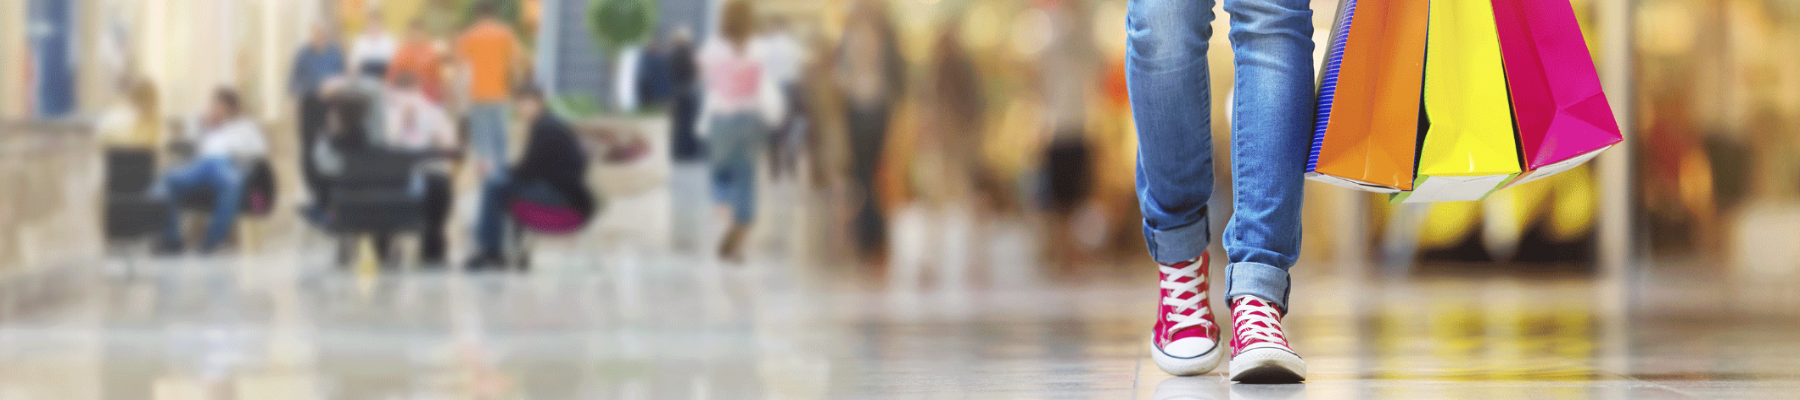

# Amazon Toy Price Prediction

Purpose of this project is to create a model that predicts toy's price based on it's description, customers' review, category, weight and other features.  
The business puprose of this project could be buying toys that have lower price than it should be and then selling those toys for a higher price.

## Import

In [ ]:
#@title
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 4.4 MB/s 


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_classif, mutual_info_classif
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.layers import *
from tensorflow import keras
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.2
Keras        : 2.8.0


In [ ]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

In [ ]:
SEED = 42

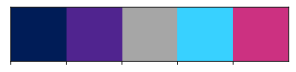

In [ ]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

## Functions

In [ ]:
def modify_cat_col(data, col, n_of_cats):
  ''' modifies column's categories by leaving only top categories (chosen by n_of_cats) '''
  
  top_category = set(data[col].value_counts()[:n_of_cats].to_dict().keys())
  other_category = set(data[col].value_counts().to_dict().keys()) - top_category
  data[col] = data[col].replace(to_replace=other_category, value='other')
  
  return data

In [ ]:
def rmse(y_pred, y_true):
  return math.sqrt(mean_squared_error(y_pred, y_true))

In [ ]:
def barh_plot(f_imp):
  ''' barh plot for catboost feature_importances visualisation '''
  f_imp.set_index('Feature Id').plot(kind='barh')

In [ ]:
def num_vis(col, title=None):
    '''Visualisation of numerical features'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
    sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')

    plt.show()

In [ ]:
def find_outliers(data):
    '''Find outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    bot = q1 - (1.5 * IQR)
    top = q3 + (1.5 * IQR)
    count = len(data[data < bot]) + len(data[data > top])

    print(f'Bot: {round(bot,3)}, Top: {round(top,3)}, Outliers: {count}')

In [ ]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [ ]:
def barh_features(imp, names, samples=15):
  feature_importance = np.array(imp)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  feat_di={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(feat_di)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  plt.barh(fi_df.feature_names[:samples], fi_df.feature_importance[:samples])

In [ ]:
def run_catboost(df, cat_cols, rand_seed=SEED, verbose_eval=100):
  df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
  y = df['price']
  X = df.drop(['price'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

  catboost_numcat = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = rand_seed,
                          eval_metric='RMSE',
                          od_wait=500,
                          train_dir='/content'
                         )
  catboost_numcat.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=verbose_eval,
          use_best_model=True,
          #plot=True,
          )
  
  test_predict_catboost = np.exp(catboost_numcat.predict(X_test))
  print(f"TEST RMSE: {(rmse(test_predict_catboost, y_test)):0.2f}")

  return catboost_numcat

In [ ]:
def run_randf(df, cat_cols, rand_seed=SEED):
  df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
  y = df['price']
  X = df.drop(['price'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
  randf_reg_numcat = RandomForestRegressor(random_state=rand_seed).fit(X_train, y_train)
  randf_numcat_predict = randf_reg_numcat.predict(X_test)
  print(f"TEST RMSE: {(rmse(randf_numcat_predict, y_test)):0.2f}")

  return randf_reg_numcat

In [ ]:
def get_train_test(df, cat_cols, num_cols, text_cols=[]):
  df = pd.get_dummies(df[cat_cols+num_cols], columns=cat_cols, dummy_na=False)
  y = df['price']
  X = df.drop(['price'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
  return X_train, X_test, y_train, y_test

## Upload

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [ ]:
df = pd.read_csv("/gdrive/MyDrive/toys_cleaned.csv")
df = df.drop(df.columns[0], axis=1)

## Text Analysis

### Preprocess columns

#### customer_reviews

Took out all available reviews for each row

In [ ]:
def get_customer_reviews(row):
  try:
    count = 0
    li = []
    for i in row.split(' // '):
      if (count % 4 == 0):
        li.append(i)
      count += 1
    return li
  except AttributeError:
    return np.nan

In [ ]:
df.customer_reviews = df.customer_reviews.apply(get_customer_reviews)

#### customer_questions_and_answers

Too many missing values, dropping the column

In [ ]:
df.customer_questions_and_answers.isna().sum()

7723

In [ ]:
df.drop(['customer_questions_and_answers'], axis=1, inplace=True)
text_cols.remove('customer_questions_and_answers')

#### product_description

Repeats 'description' column. Dropping

In [ ]:
df.drop(['product_description'], axis=1, inplace=True)
text_cols.remove('product_description')

#### description

Pretty much each row is unique, no special pattern. Will continue to work with the column in next section

In [ ]:
df.description[0]

'Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue'

In [ ]:
df.description[2]

'BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT ENGINE SOUND BOXED KIDS BATTERY Railway Train Set with Light Sound, Big Size Curved Track Free Wheeling Action Working Headlight Sound Horn The Track Can Also Be Assembled In More Layouts Length Of Track 104 cm WIDTH OF THE TRACK 68 CM Finely Detailed Realistic Toy Train REQUIRES 2 AA BATTERIES (NOT INCLUDED)'

### Tokenize + Lemmatize

Let's try to use CatBoost's tokenizer for tokenization nltk lemmatizer

#### customer_reviews

In [ ]:
text_cols

['description', 'customer_reviews']

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
text_df = df.copy()

In [ ]:
from catboost.text_processing import Tokenizer, Dictionary

In [ ]:
tokenized = Tokenizer(lowercasing=True, separator_type='BySense', languages=['eng'])

dictionary = Dictionary(occurence_lower_bound=5)\
     .fit(text_df['customer_reviews'],\
     tokenizer=tokenized)

In [ ]:
def tokenize_cb_cust_reviews(text_list):
  new_list = []
  for text in text_list:
    new_list.append(tokenized.tokenize(text))
  return new_list

In [ ]:
text_df.customer_reviews[text_df.customer_reviews.notna()] = text_df[text_df.customer_reviews.notna()].apply(lambda text_df: tokenize_cb_cust_reviews(text_df.customer_reviews), axis=1)

In [ ]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

In [ ]:
english_stopwords = stopwords.words("english")

def clear_stopwords_cust_reviews(text_list):
  final_list = []
  for text in text_list:
    new_list = []
    for word in text:
      if word not in english_stopwords:
        new_list.append(word)
    final_list.append(' '.join(new_list))
  return final_list

In [ ]:
text_df.customer_reviews[text_df.customer_reviews.notna()] = text_df[text_df.customer_reviews.notna()].customer_reviews.apply(clear_stopwords_cust_reviews)

In [ ]:
df.customer_reviews[0][0]

'Worth Buying For The Pictures Alone (As Ever)'

In [ ]:
text_df.customer_reviews[0][0]

'worth buying pictures alone ever'

#### description

Column contains mainly technical information, written by the seller/manufacturer.

In [ ]:
tokenized.tokenize(df.description[0])

['product',
 'description',
 'hornby',
 '2014',
 'catalogue',
 'box',
 'contains',
 '1',
 'x',
 'one',
 'catalogue']

In [ ]:
def clear_stopwords_description(text):
  final_list = []
  for word in text:
    if word not in english_stopwords:
      final_list.append(word)
  return ' '.join(final_list)

In [ ]:
text_df.description[text_df.description.notna()] = text_df[text_df.description.notna()].description.apply(lambda x: tokenized.tokenize(x))

In [ ]:
text_df.description[text_df.description.notna()] = text_df[text_df.description.notna()].description.apply(clear_stopwords_description)

In [ ]:
df.description[0]

'Product Description Hornby 2014 Catalogue Box Contains 1 x one catalogue'

In [ ]:
text_df.description[0]

'product description hornby 2014 catalogue box contains 1 x one catalogue'

In [ ]:
df.description = text_df.description.copy()
df.customer_reviews = text_df.customer_reviews.copy()

Fill missing values in description with basic product description based on other columns

In [ ]:
df.description.isna().sum()

553

In [ ]:
def fillna_description(df):
  if type(df.description) == float:
    df.description = f"Manufactured by {df.manufacturer} available in stock {df.number_available_in_stock} sub_category {df.sub_category} weight {df.weight_g}"
  return df



In [ ]:
df = df.apply(fillna_description, axis=1)

In [ ]:
df.description.isna().sum()

0

### Sentiment Analysis

#### customer_reviews

Due to the fact, that there are multiple reviews for each product, I consider calculating average score for each product based on all reviews.  
Each text should not be longer than 512 symbols.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 18.6 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 


In [ ]:
from transformers import pipeline

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
testing_text = text_df.customer_reviews[0]
sentiment_pipeline(testing_text)

[{'label': 'POSITIVE', 'score': 0.9998170733451843},
 {'label': 'POSITIVE', 'score': 0.9995446801185608},
 {'label': 'POSITIVE', 'score': 0.9990641474723816},
 {'label': 'POSITIVE', 'score': 0.9986876845359802},
 {'label': 'POSITIVE', 'score': 0.9988507032394409},
 {'label': 'POSITIVE', 'score': 0.9993452429771423},
 {'label': 'POSITIVE', 'score': 0.999833345413208},
 {'label': 'POSITIVE', 'score': 0.9606593251228333},
 {'label': 'POSITIVE', 'score': 0.9998555183410645}]

In [ ]:
testing_text

['worth buying pictures alone ever',
 "part magic growing boy buy given new hornby catalogue every year even included 90 products previous year i've still got old ones dating back 70s 80s somewhere days catalogue especially informative tells vintage rolling stock useful dedicating railway one particular era train company amazing detail fabulous photography",
 'amazing detail every credit photographer book worthy reference manual well sales brochure even passing interest hobby transported another time younger awe big trains great purchase',
 'purchased behalf dad always asking look 00 gauge engines online good buy look anytime would definitely buy next one 2015 arrived quickly perfect condition great catalogue',
 'everything really needed see offer hornby way trains would minded included rrp well though collect glossy pictures great nice still get',
 'collect glossy pictures great nice still get catalogs collect great catalogue',
 'great book extremely useful insight future christmas pr

In [ ]:
data.customer_reviews[0]

"Worth Buying For The Pictures Alone (As Ever) // 4.0 // 6 April 2014 // By\n    \n    Copnovelist\n  \n on 6 April 2014 // Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year.  I've still got my old ones dating back to the 70s and 80s somewhere.  These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company. | Amazing detail fabulous photography. // 5.0 // 11 April 2015 // By\n    \n    richard\n  \n on 11 April 2015 // Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains. | 'Great Purchase' // 5.0 // 23 April 2014 // By\n  

In [ ]:
sentiment_pipeline(testing_text)[0]['label']

'POSITIVE'

In [ ]:
def str_limit_512(row):
  new_list = []
  for text in row:
    new_list.append(text[:512])
  return new_list

In [ ]:
df.customer_reviews[df.customer_reviews.notna()] = df.customer_reviews[df.customer_reviews.notna()].apply(str_limit_512)

In [ ]:
def get_average_sentiment_score(row):
  ''' makes sentiment analysis of all reviews for an item 
      and returns average score '''
  score_list = []
  if type(row) == list:
    for i in sentiment_pipeline(row):
      if i['label'] == 'NEGATIVE':
        i['score'] = -i['score']
      score_list.append(i['score'])
    return round(np.average(score_list), 4)
  else:
    return None


In [ ]:
# df['average_sentiment_score'] = df.customer_reviews.apply(get_average_sentiment_score)

In [ ]:
df.average_sentiment_score = np.round(df.average_sentiment_score, 4)
df.average_sentiment_score.describe()

In [ ]:
# dropping 17 missing values
df.dropna(axis=0, subset=['customer_reviews'], inplace=True)

In [ ]:
df = df.reset_index().drop(['index'], axis=1)

In [ ]:
# %cd /content
# df.to_csv('toys_cleaned_2.csv')
# !cp toys_cleaned_2.csv "/gdrive/MyDrive/"

/content


Loading from drive to save some time

In [ ]:
df = pd.read_csv("/gdrive/MyDrive/toys_cleaned_2.csv")
df = df.drop(df.columns[0], axis=1)

In [ ]:
num_cols.append('average_sentiment_score')

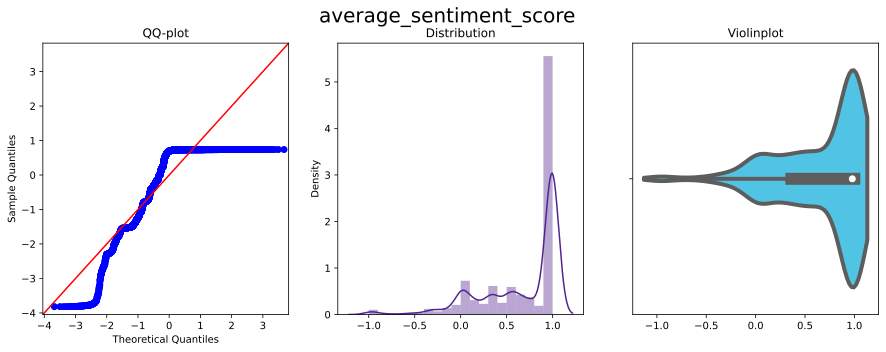

Bot: -0.595, Top: 1.956, Outliers: 122


In [ ]:
num_vis((df['average_sentiment_score'].dropna()), title='average_sentiment_score')
find_outliers(df['average_sentiment_score'].dropna())

### Tokenize

#### description

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df, cat_cols, num_cols, text_cols)

In [ ]:
# split
# text_train = df.description.iloc[X_train.index]
# text_test = df.description.iloc[X_test.index]

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df.description)

CPU times: user 335 ms, sys: 3.83 ms, total: 339 ms
Wall time: 338 ms


In [ ]:
tokenize.word_index

{'1': 1,
 'x': 2,
 'product': 3,
 'description': 4,
 'box': 5,
 'contains': 6,
 '3': 7,
 '2': 8,
 'set': 9,
 'one': 10,
 'children': 11,
 'model': 12,
 'new': 13,
 'quality': 14,
 'high': 15,
 '4': 16,
 '5': 17,
 'fun': 18,
 'play': 19,
 'made': 20,
 'cards': 21,
 'years': 22,
 'suitable': 23,
 'scale': 24,
 'use': 25,
 'great': 26,
 'game': 27,
 'includes': 28,
 'available': 29,
 'figure': 30,
 '6': 31,
 'card': 32,
 'size': 33,
 'pack': 34,
 'range': 35,
 '0': 36,
 '£': 37,
 'items': 38,
 'toys': 39,
 'make': 40,
 'also': 41,
 '10': 42,
 'features': 43,
 'toy': 44,
 'weight': 45,
 'hand': 46,
 'puppet': 47,
 'item': 48,
 'puzzle': 49,
 'colour': 50,
 'cm': 51,
 'ages': 52,
 '8': 53,
 'perfect': 54,
 'included': 55,
 'easy': 56,
 'in': 57,
 'design': 58,
 'manufactured': 59,
 'car': 60,
 'comes': 61,
 'time': 62,
 'pieces': 63,
 'dice': 64,
 'two': 65,
 'stock': 66,
 'party': 67,
 'combined': 68,
 'plastic': 69,
 'many': 70,
 'black': 71,
 'accessories': 72,
 'world': 73,
 '12': 74,
 